In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/climate-data-oxford/final_data.csv
/kaggle/input/climate-data-oxford/oxforddata.csv
/kaggle/input/climate-data-oxford/oxforddata.txt


In [2]:
df = pd.read_csv("/kaggle/input/climate-data-oxford/final_data.csv")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2024-06-20 16:59:37.761196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 16:59:37.761415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 16:59:37.908691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = df.set_index('date')
df = df.drop(columns=['yyyy', 'mm'])
del df['monthly_temp_variation'] 
features = ['tmax', 'tmin', 'af_days', 'sun_hours', 'temp_range', 'season']
target = 'avg_temp'

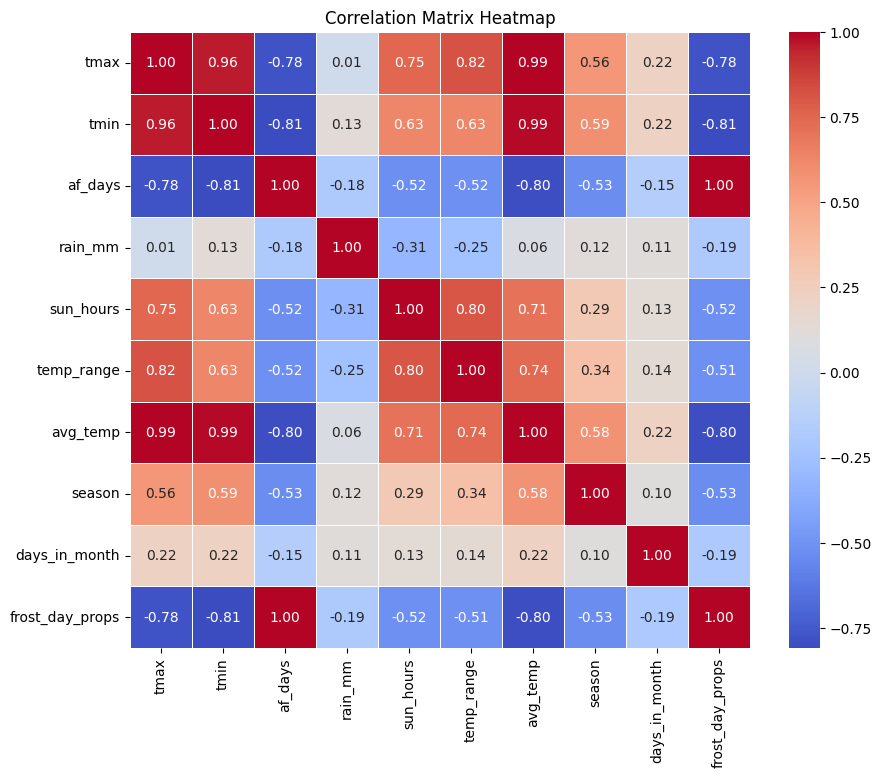

In [5]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))  # Adjust the size to fit your needs
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [6]:
# Scale the features and the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[features])
scaled_target = scaler.fit_transform(df[[target]])

# Convert to DataFrame for better manipulation
scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df[target] = scaled_target


# Scale the features and the target variable separately
# scaler_features = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler_features.fit_transform(df[features])

# scaler_target = MinMaxScaler(feature_range=(0, 1))
# scaled_target = scaler_target.fit_transform(df[[target]])

# # Convert to DataFrame for better manipulation
# scaled_df = pd.DataFrame(scaled_features, columns=features)
# scaled_df[target] = scaled_target

In [7]:
def create_sequences(data, seq_length, target_col):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].drop(columns=[target_col]).values
        y = data.iloc[i + seq_length][target_col]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
future_steps = 12
X, y = create_sequences(scaled_df, seq_length, target)

split = int(0.6 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.1380 - val_loss: 0.0403
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0357 - val_loss: 0.0298
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0220 - val_loss: 0.0101
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0061 - val_loss: 0.0080
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0042 - val_loss: 0.0070
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 12/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0

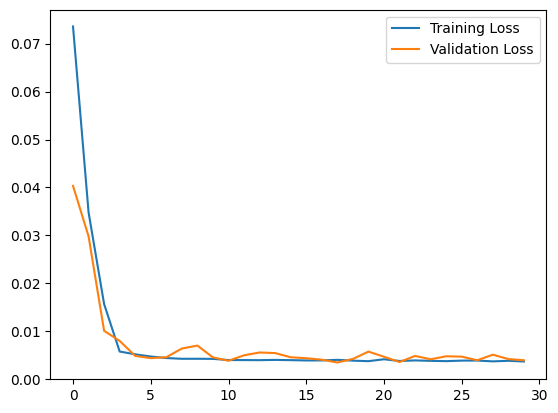

In [9]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))
model.save('cc.h5')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


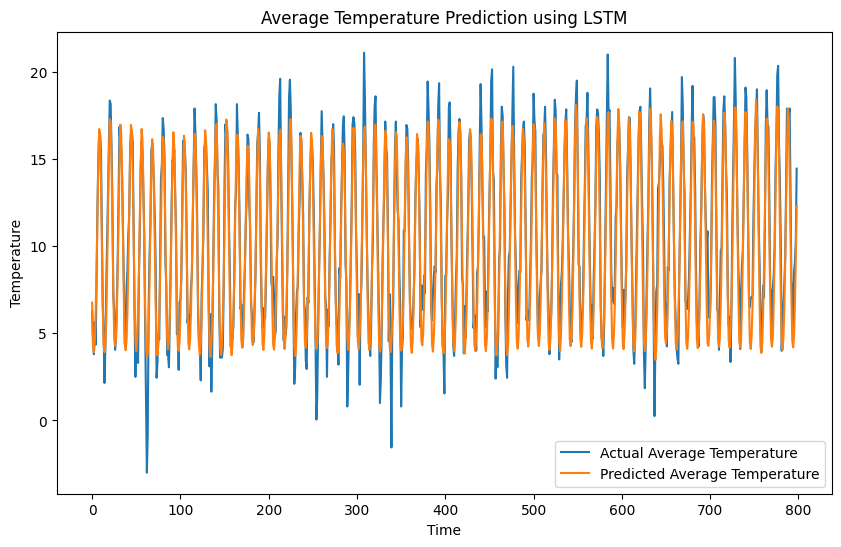

In [10]:
# Predict using the test data
predicted = model.predict(X_test)
predicted_inv = scaler.inverse_transform(predicted)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Average Temperature')
plt.plot(predicted_inv, label='Predicted Average Temperature')
plt.title("Average Temperature Prediction using LSTM")
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE
mae = mean_absolute_error(y_test_inv, predicted_inv)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(y_test_inv, predicted_inv)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((y_test_inv - predicted_inv) / y_test_inv)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 1.180162509362002
Mean Squared Error (MSE): 2.2956115437339553
Root Mean Squared Error (RMSE): 1.5151275668187003
Mean Absolute Percentage Error (MAPE): 29.65%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/tmp/ipykernel_18/1354842605.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[0, -1] = next_pred  # Assume the predicted value is the last feature


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/tmp/ipykernel_18/1354842605.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_indices = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')


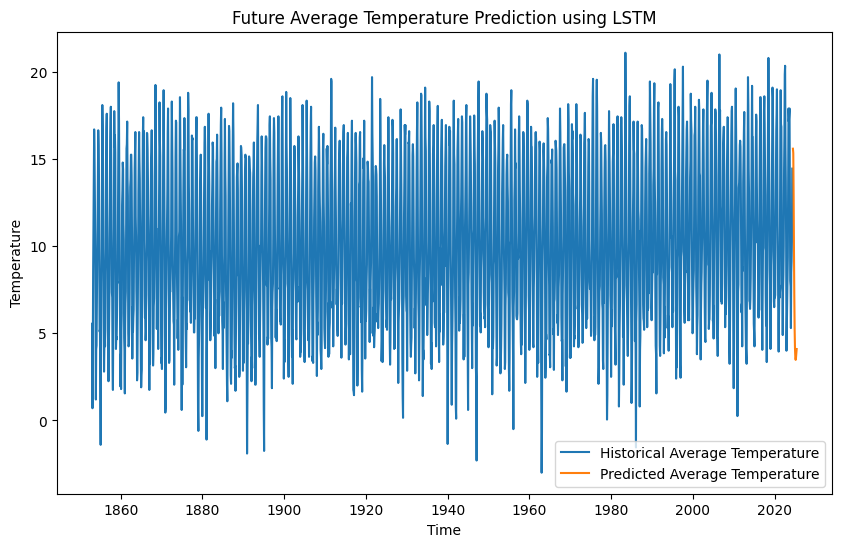

In [12]:
# Load the saved model
from tensorflow.keras.models import load_model
df.index = pd.to_datetime(df.index)

model = load_model('/kaggle/working/cc.h5')

# Initial data point for prediction
current_data = scaled_df.iloc[-seq_length:].drop(columns=[target]).values.reshape((1, seq_length, len(features)))

# List to store predicted values
future_steps = 12
future_predictions = []

for _ in range(future_steps):
    # Predict next time step
    next_pred = model.predict(current_data)
    future_predictions.append(next_pred[0, 0])
    
    # Create a new row with the predicted value and placeholders for other features
    new_row = np.zeros((1, len(features)))
    new_row[0, -1] = next_pred  # Assume the predicted value is the last feature
    
    # Update current_data to include the new row and remove the first time step
    new_data_point = np.append(current_data[0, 1:, :], new_row, axis=0)
    current_data = new_data_point.reshape((1, seq_length, len(features)))

# Invert scaling to get actual average temperature predictions
predicted_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future time indices for plotting
future_indices = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[target], label='Historical Average Temperature')
plt.plot(future_indices, predicted_inv, label='Predicted Average Temperature')
plt.title("Future Average Temperature Prediction using LSTM")
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [13]:
predictions = pd.DataFrame(index=future_indices,data=predicted_inv)
predictions

,0
2024-06-30,15.592974
2024-07-31,15.343642
2024-08-31,12.962516
2024-09-30,9.862994
2024-10-31,7.158186
2024-11-30,5.261328
2024-12-31,4.132805
2025-01-31,3.597590
2025-02-28,3.476381
2025-03-31,3.609819
